# Multiclass Classification

In [2]:
import os

from tqdm import tqdm
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import matplotlib.pyplot as plt

In [3]:
data_folder = "data"
stack_name = os.path.join(data_folder, "data_stack.h5")
df_stack = pd.read_hdf(stack_name)

model_folder = "model"

In [4]:
def labeling(x, qs):
    for i, q in enumerate(qs):
        if x < q:
            return i + 1
    return len(qs) + 1

In [5]:
def q_labeling(train_df, test_df):
    train_labels = []
    test_labels = []

    sectors = train_df['fgsc'].unique()
    dates = train_df.index.get_level_values(0).unique()

    for sector in sectors:
        qs_list = []

        sector_mask_train = (train_df['fgsc']==sector)
        sector_mask_test = (test_df['fgsc']==sector)

        df_train_sector = train_df[sector_mask_train]
        df_test_sector = test_df[sector_mask_test]

        for dt in dates:
            date_mask = (df_train_sector.index.get_level_values(0)==dt)
            df_temp = df_train_sector[date_mask]

            qs = [df_temp['target'].quantile(i/5) for i in range(1, 5)]
            qs_list.append(qs)

        # median value to represent time-series wise
        qs_median = pd.DataFrame(qs_list).median().to_list()
        train_labels.append(df_train_sector['target'].apply(labeling, qs=qs_median))
        test_labels.append(df_test_sector['target'].apply(labeling, qs=qs_median))

    q_train = pd.concat(train_labels).loc[train_df.index]
    q_test = pd.concat(test_labels).loc[test_df.index]
    return q_train, q_test

In [6]:
df_isos_year = {}

for year in range(2018, 2023):
    index_year_1 = (df_stack.index.get_level_values(0).year<=year)
    index_year_2 = (df_stack.index.get_level_values(0).year<=year+1)

    df_stack_is = df_stack[index_year_1]
    df_stack_os = df_stack[~index_year_1&index_year_2]
    df_isos_year[year] = [df_stack_is.copy(), df_stack_os.copy()]

In [7]:
features = list(df_stack.columns)[:-1]
target = list(df_stack.columns)[-1]

categorical_columns = ['fgsc']

## Model fitting with Linear sample weight decay

In [16]:
models_dict = {}
for year in range(2018, 2023):
    print(f"######## Year {year} ########")
    df_stack_is_c = df_isos_year[year][0].copy()

    X = df_stack_is_c[features]
    y = df_stack_is_c[target]

    kf_results = []

    model = CatBoostClassifier(cat_features=categorical_columns, verbose=0)

    param_grid = {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1]
    }

    best_params = {
        'depth': 4,
        'learning_rate': 0.01
    }

    cv = StratifiedKFold(n_splits=5)

    y_total = np.ones(np.shape(y))
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y_total)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        # time series consistency
        valid_start = X_valid.index.get_level_values(0)[0]
        valid_end = X_valid.index.get_level_values(0)[-1]

        if fold == 0:
            X_train = X[X.index.get_level_values(0)>valid_end]
            X_valid = X[X.index.get_level_values(0)<=valid_end]
            y_train = y[y.index.get_level_values(0)>valid_end]
            y_valid = y[y.index.get_level_values(0)<=valid_end]
        elif fold == 4:
            X_train = X[X.index.get_level_values(0)<valid_start]
            X_valid = X[X.index.get_level_values(0)>=valid_start]
            y_train = y[y.index.get_level_values(0)<valid_start]
            y_valid = y[y.index.get_level_values(0)>=valid_start]
        else:
            X_train = X[(X.index.get_level_values(0)<valid_start)|(X.index.get_level_values(0)>valid_end)]
            X_valid = X[(X.index.get_level_values(0)>=valid_start)&(X.index.get_level_values(0)<=valid_end)]
            y_train = y[(y.index.get_level_values(0)<valid_start)|(y.index.get_level_values(0)>valid_end)]
            y_valid = y[(y.index.get_level_values(0)>=valid_start)&(y.index.get_level_values(0)<=valid_end)]

        # embargo 1 month
        if fold > 0:
            dt = X_valid.index.get_level_values(0)[0]
            X_valid = X_valid[X_valid.index.get_level_values(0)>dt]
            y_valid = y_valid[y_valid.index.get_level_values(0)>dt]
        else:
            pass

        # quintile labeling
        df_train, df_valid = df_stack_is.loc[y_train.index], df_stack_is.loc[y_valid.index]
        y_train, y_valid = q_labeling(df_train, df_valid)

        # linear sample weight decay
        sample_weights = y_train.index.get_level_values(0).to_series().rank(pct=True)
        sample_weights = (sample_weights / sample_weights.sum()).to_numpy()

        """
        grid_search = GridSearchCV(model, param_grid,
                                   cv=StratifiedKFold(n_splits=3),
                                   scoring='accuracy', verbose=0)
        grid_search.fit(X_train, y_train, sample_weight=sample_weights)

        print(f"End of Fold {fold+1}: Score - {grid_search.best_score_:.4f}")
        print(f"Best Params - {grid_search.best_params_}")

        best_params = grid_search.best_params_
        """

        best_model = CatBoostClassifier(cat_features=categorical_columns,
                                        verbose=0, **best_params)
        best_model.fit(X_train, y_train, sample_weight=sample_weights)

        y_pred_kf = best_model.predict(X_valid)
        accuracy_kf = accuracy_score(y_valid, y_pred_kf)
        kf_results.append(accuracy_kf)
        print(f'K-Fold Split {fold + 1} Accuracy: {accuracy_kf:.4f}')

    kf_mean_accuracy = np.mean(kf_results)
    print(f'K-Fold Mean Accuracy: {kf_mean_accuracy:.4f}')

    tscv_results = []
    # TSCV
    tscv = TimeSeriesSplit(n_splits=5)
    for fold, (train_idx, valid_idx) in enumerate(tscv.split(X, y_total)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # time series consistency
        valid_start = X_valid.index.get_level_values(0)[0]
        valid_end = X_valid.index.get_level_values(0)[-1]

        X_train = X[X.index.get_level_values(0)<valid_start]
        X_valid = X[X.index.get_level_values(0)>=valid_start]
        y_train = y[y.index.get_level_values(0)<valid_start]
        y_valid = y[y.index.get_level_values(0)>=valid_start]

        # quintile labeling
        df_train, df_valid = df_stack_is.loc[y_train.index], df_stack_is.loc[y_valid.index]
        y_train, y_valid = q_labeling(df_train, df_valid)

        # linear sample weight decay
        sample_weights = y_train.index.get_level_values(0).to_series().rank(pct=True)
        sample_weights = (sample_weights / sample_weights.sum()).to_numpy()

        model = best_model
        """
        grid_search = GridSearchCV(model, param_grid,
                               cv=TimeSeriesSplit(n_splits=3),
                               scoring='accuracy', verbose=0)
        grid_search.fit(X_train, y_train, sample_weight=sample_weights)

        print(f"End of Fold {fold+1}: Score - {grid_search.best_score_:.4f}")
        print(f"Best Params - {grid_search.best_params_}")

        best_params = grid_search.best_params_
        """
        best_model = CatBoostClassifier(cat_features=categorical_columns,
                                        verbose=0, **best_params)
        best_model.fit(X_train, y_train, sample_weight=sample_weights)

        y_pred_tscv = best_model.predict(X_valid)
        accuracy_tscv = accuracy_score(y_valid, y_pred_tscv)
        tscv_results.append(accuracy_tscv)
        print(f'TSCV Split {fold + 1} Accuracy: {accuracy_tscv:.4f}')

    tscv_mean_accuracy = np.mean(tscv_results)
    print(f'TSCV Mean Accuracy: {tscv_mean_accuracy:.4f}')

    models_dict[year] = [best_model]

######## Year 2018 ########
K-Fold Split 1 Accuracy: 0.2523
K-Fold Split 2 Accuracy: 0.2327
K-Fold Split 3 Accuracy: 0.2550
K-Fold Split 4 Accuracy: 0.2050
K-Fold Split 5 Accuracy: 0.2103
K-Fold Mean Accuracy: 0.2311
TSCV Split 1 Accuracy: 0.2336
TSCV Split 2 Accuracy: 0.2163
TSCV Split 3 Accuracy: 0.2305
TSCV Split 4 Accuracy: 0.2190
TSCV Split 5 Accuracy: 0.2154
TSCV Mean Accuracy: 0.2229
######## Year 2019 ########
K-Fold Split 1 Accuracy: 0.2600
K-Fold Split 2 Accuracy: 0.2492
K-Fold Split 3 Accuracy: 0.2518
K-Fold Split 4 Accuracy: 0.2272
K-Fold Split 5 Accuracy: 0.2098
K-Fold Mean Accuracy: 0.2396
TSCV Split 1 Accuracy: 0.2152
TSCV Split 2 Accuracy: 0.2185
TSCV Split 3 Accuracy: 0.2124
TSCV Split 4 Accuracy: 0.2214
TSCV Split 5 Accuracy: 0.2196
TSCV Mean Accuracy: 0.2174
######## Year 2020 ########
K-Fold Split 1 Accuracy: 0.2524
K-Fold Split 2 Accuracy: 0.2520
K-Fold Split 3 Accuracy: 0.2176
K-Fold Split 4 Accuracy: 0.2250
K-Fold Split 5 Accuracy: 0.2315
K-Fold Mean Accuracy: 0.

## Model Evaluation

### Linear Decay

In [20]:
y_hats = []
y_trues = []

for year in range(2018, 2023):
    df_stack_is_c = df_isos_year[year][0].copy()
    df_stack_os_c = df_isos_year[year][1].copy()

    X_test = df_stack_os_c[features]
    y_test = df_stack_os_c[target]

    best_model = models_dict[year][0]
    predictions = best_model.predict(X_test)
    y_hats.append(predictions.reshape((len(predictions))))
    y_trues.append((q_labeling(df_stack_is_c, df_stack_os_c)[1]).to_numpy())

y_hat = np.concatenate(tuple(y_hats))
y_true = np.concatenate(tuple(y_trues))

In [21]:
test_score = accuracy_score(y_hat, y_true)
print(f"Test Accuracy: {test_score:.4f}")

Test Accuracy: 0.2438


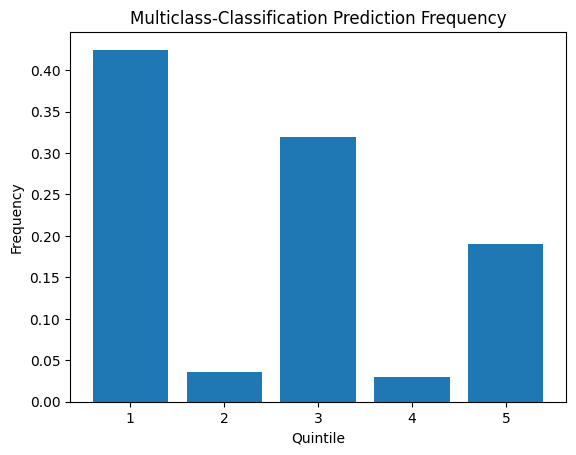

In [22]:
df_hat = pd.DataFrame({'predict':y_hat, 'true':y_true})
prediction_frequency_name = os.path.join(model_folder, f"Prediction_Frequency.png")
x_bar = [1, 2, 3, 4, 5]
fig3, ax3 = plt.subplots()
predict_count = df_hat['predict'].value_counts().sort_index()
predict_count = predict_count / predict_count.sum()
ax3.bar(x_bar, predict_count)
ax3.set_title("Multiclass-Classification Prediction Frequency")
ax3.set_xlabel("Quintile")
ax3.set_ylabel("Frequency")
fig3.figure.savefig(prediction_frequency_name, bbox_inches='tight', dpi=300)

In [23]:
true_dict = dict()
for i in range(1, 6):
    true_count = df_hat[df_hat['predict']==i]['true'].value_counts().sort_index()
    true_count = true_count / true_count.sum()
    true_dict[i] = true_count

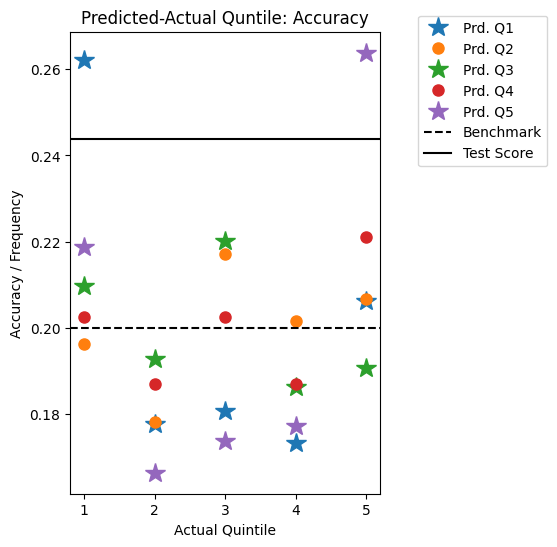

In [24]:
actual_frequency_name = os.path.join(model_folder, f"Actual_Frequency.png")
x_bar = [1, 2, 3, 4, 5]
fig3, ax3 = plt.subplots(figsize=(4,6))
ax3.plot(x_bar, true_dict[1], "*", markersize=15, label="Prd. Q1")
ax3.plot(x_bar, true_dict[2], "o", markersize=8, label="Prd. Q2")
ax3.plot(x_bar, true_dict[3], "*", markersize=15, label="Prd. Q3")
ax3.plot(x_bar, true_dict[4], "o", markersize=8, label="Prd. Q4")
ax3.plot(x_bar, true_dict[5], "*", markersize=15, label="Prd. Q5")
ax3.axhline(y=0.20, c="black", ls="--", label="Benchmark")
ax3.axhline(y=test_score, c="black", label="Test Score")
ax3.set_title("Predicted-Actual Quntile: Accuracy")
ax3.set_xticks([1, 2, 3, 4, 5])
ax3.set_xlabel("Actual Quintile")
ax3.set_ylabel("Accuracy / Frequency")
ax3.legend(bbox_to_anchor=(1.1, 1.05))
fig3.figure.savefig(actual_frequency_name, bbox_inches='tight', dpi=300)

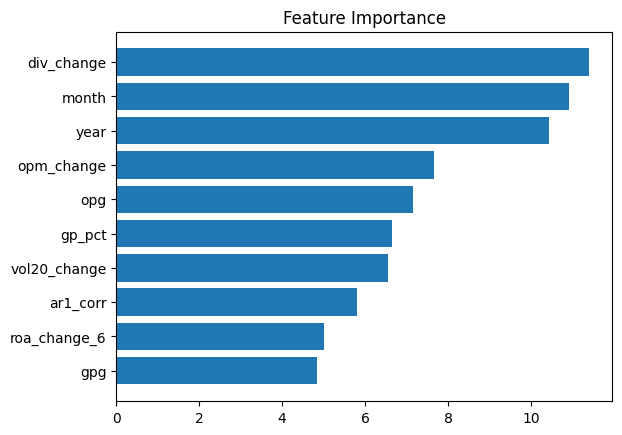

In [25]:
importance_name = os.path.join(model_folder, f"Importance.png")
df_importance = best_model.get_feature_importance(prettified=True)
df_importance = df_importance.sort_values(by='Importances').iloc[-10:]
fig7, ax7 = plt.subplots()
ax7.barh(df_importance['Feature Id'], df_importance['Importances'])
ax7.set_title("Feature Importance")
fig7.figure.savefig(importance_name, bbox_inches='tight', dpi=300)

## Save Model

In [26]:
model_folder = "model"
for key in models_dict.keys():
    model_name = os.path.join(model_folder, f"cat_{key}.json")
    models_dict[key][0].save_model(model_name, format="cbm",
                                     export_parameters=None, pool=None)